# Multi-class classification with Word2Vec

In [159]:
# Import necessary libraries
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('arxiv100.csv')

# Drop the abstract column and keep only the title and label
df1 = df.drop(columns=['abstract'])
sentences = []
for title in df1['title']:
    t = title.split()
    sentences.append(t)

# Drop the title column and keep only the abstract and label
df2 = df.drop(columns=['title'])
sentences_a = []
for abstract in df2['abstract']:
    a = abstract.split()
    sentences_a.append(a)

df.head()

,title,abstract,label
0,The Pre-He White Dwarfs in Eclipsing Binaries....,We report the first $BV$ light curves and hi...,astro-ph
1,A Possible Origin of kHZ QPOs in Low-Mass X-ra...,A possible origin of kHz QPOs in low-mass X-...,astro-ph
2,The effects of driving time scales on heating ...,Context. The relative importance of AC and D...,astro-ph
3,A new hard X-ray selected sample of extreme hi...,Extreme high-energy peaked BL Lac objects (E...,astro-ph
4,The baryon cycle of Seven Dwarfs with superbub...,"We present results from a high-resolution, c...",astro-ph


In [160]:
# Train Word2Vec model with titles/abstracts
# The first three models are for titles with different hyperparameters
# The fourth model is for the abstracts

model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model.train(sentences, total_examples=len(sentences), epochs=10)

model1 = Word2Vec(sentences, vector_size=150, window=10, min_count=1, workers=4)
model1.train(sentences, total_examples=len(sentences), epochs=10)

model2 = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
model2.train(sentences, total_examples=len(sentences), epochs=20)

model_abstract = Word2Vec(sentences_a, vector_size=100, window=5, min_count=1, workers=4)
model_abstract.train(sentences_a, total_examples=len(sentences_a), epochs=10)

# Get word embeddings
word_embeddings = model.wv
word_embeddings_a = model_abstract.wv

# Visualize title word embeddings using t-SNE
def tsne_plot(model):
    labels = []
    wordvecs = []

    count = 0
    for word in model.wv.key_to_index:
        if count >= 500:
            break
        wordvecs.append(model.wv[word])
        labels.append(word)
        count += 1

    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()



# Example application: similarity between words
similarity = model.wv.similarity('application', 'applications')
print("Similarity between 'word1' and 'word2':", similarity)


Similarity between 'word1' and 'word2': 0.9029099


# Visualizations for first 500 Word2Vec embeddings using t-SNE 

Embedding visualization for vector size = 100, window size = 5, epochs = 10


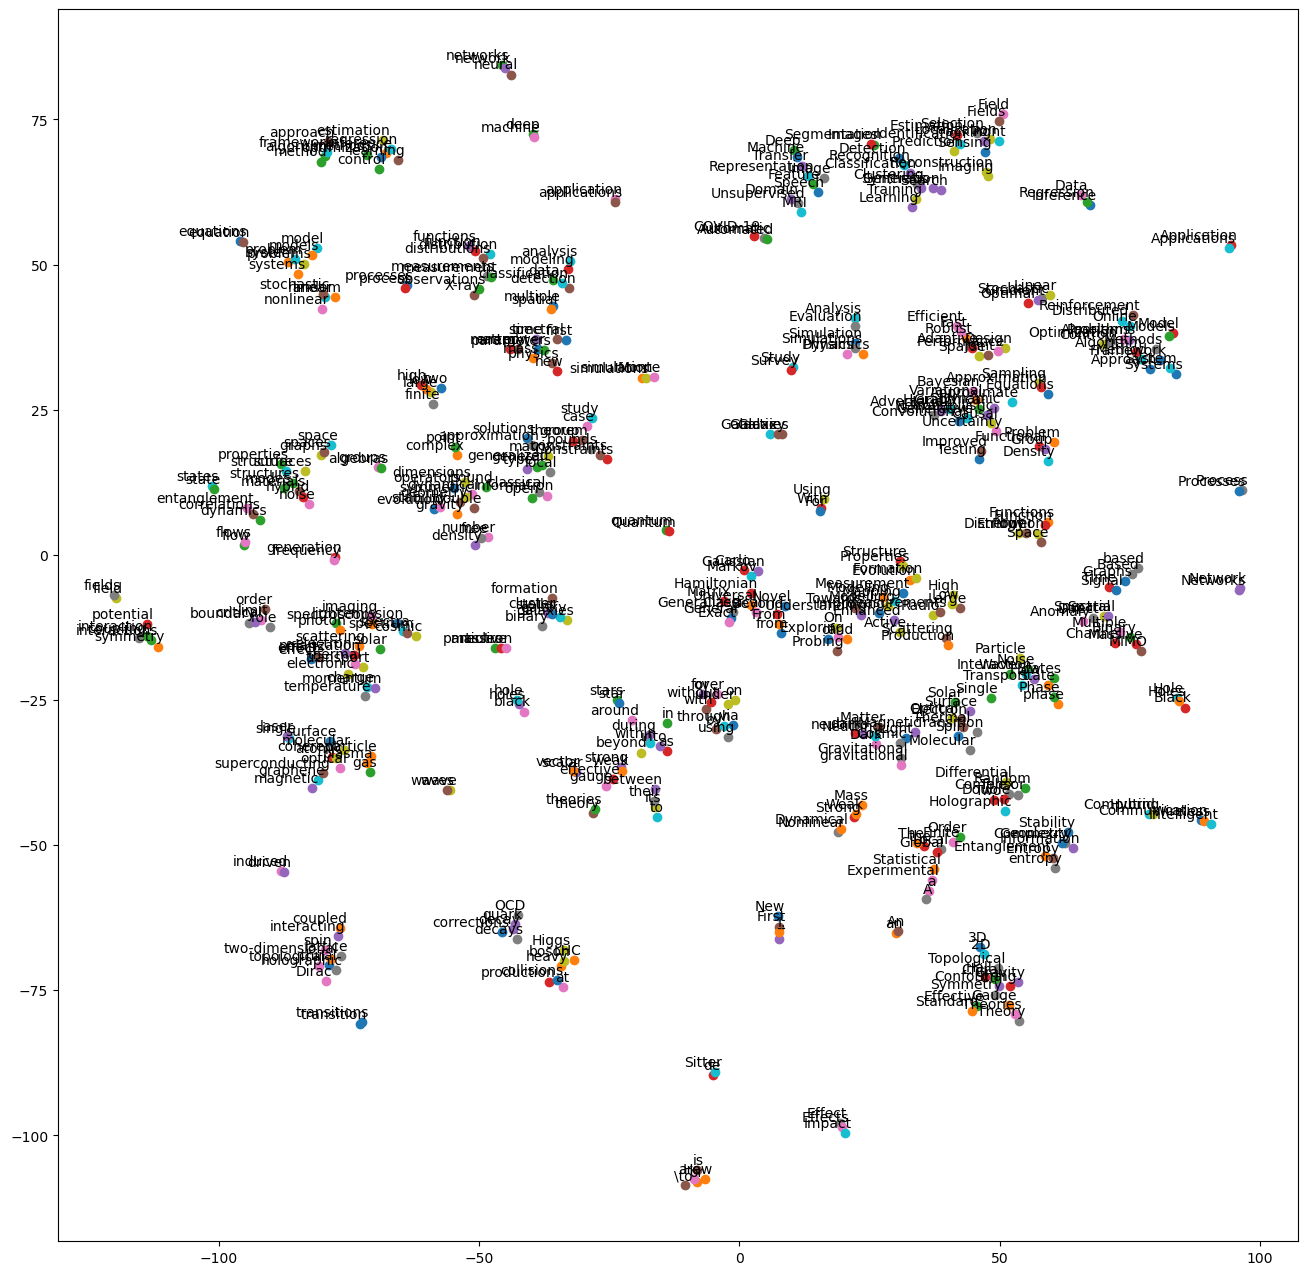

Embedding visualization for vector size = 150, window size = 10, epochs = 10


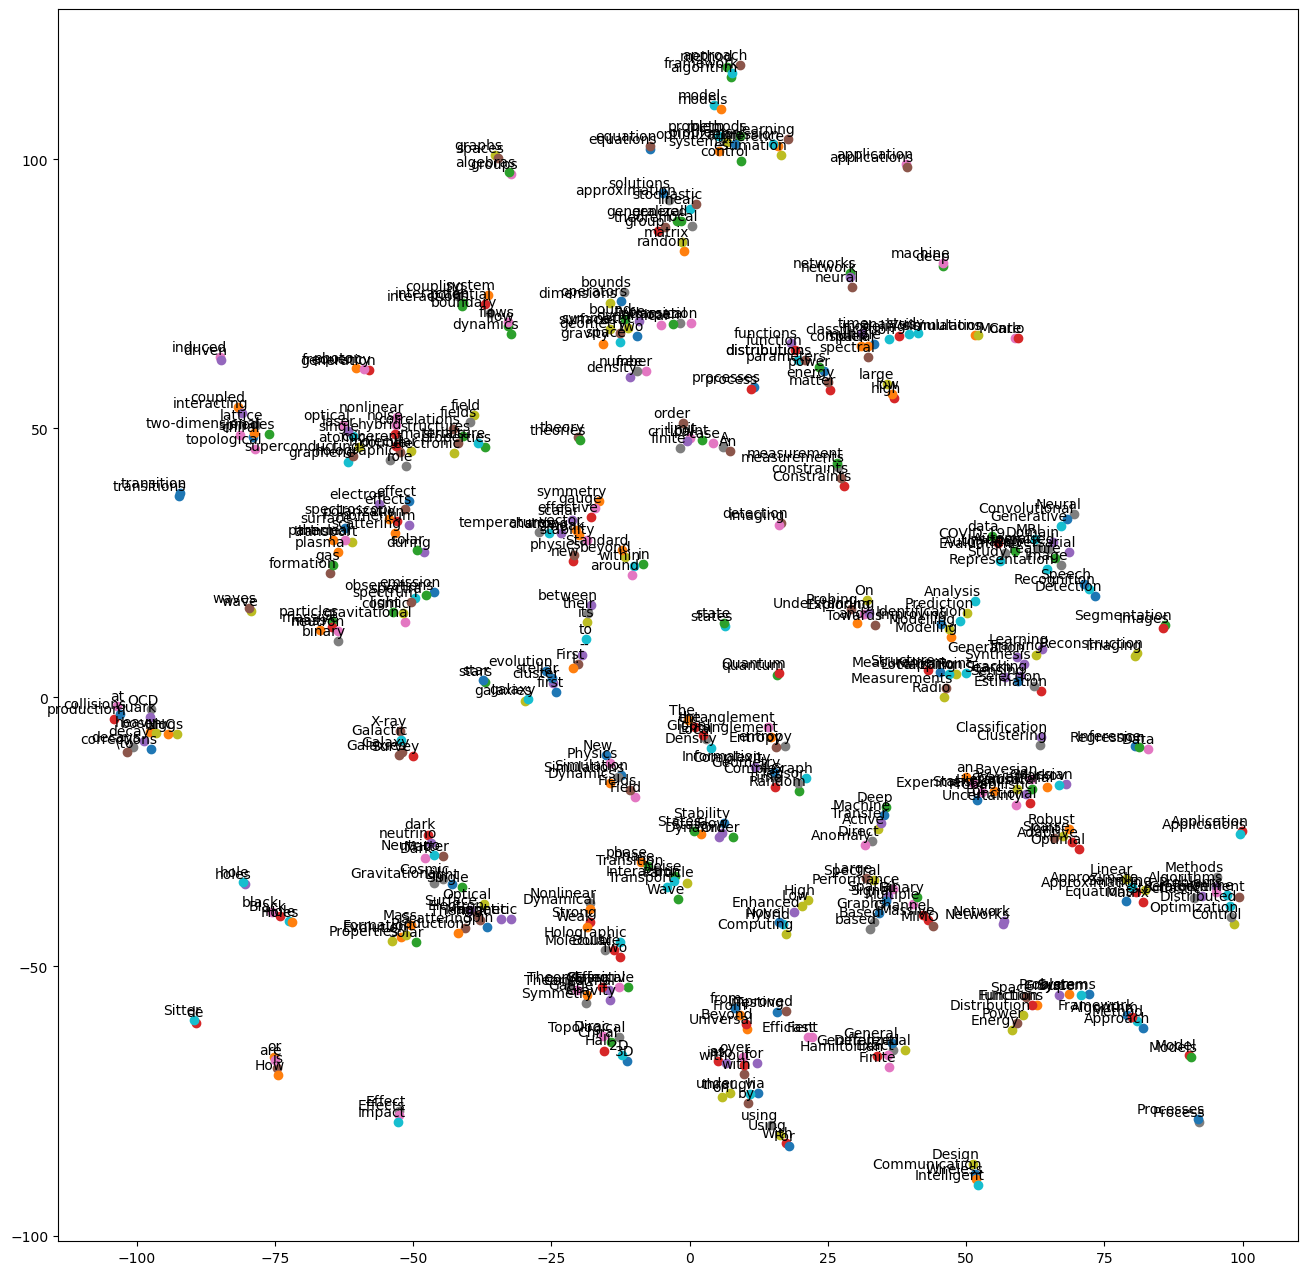

Embedding visualization for vector size = 100, window size = 5, epochs = 20


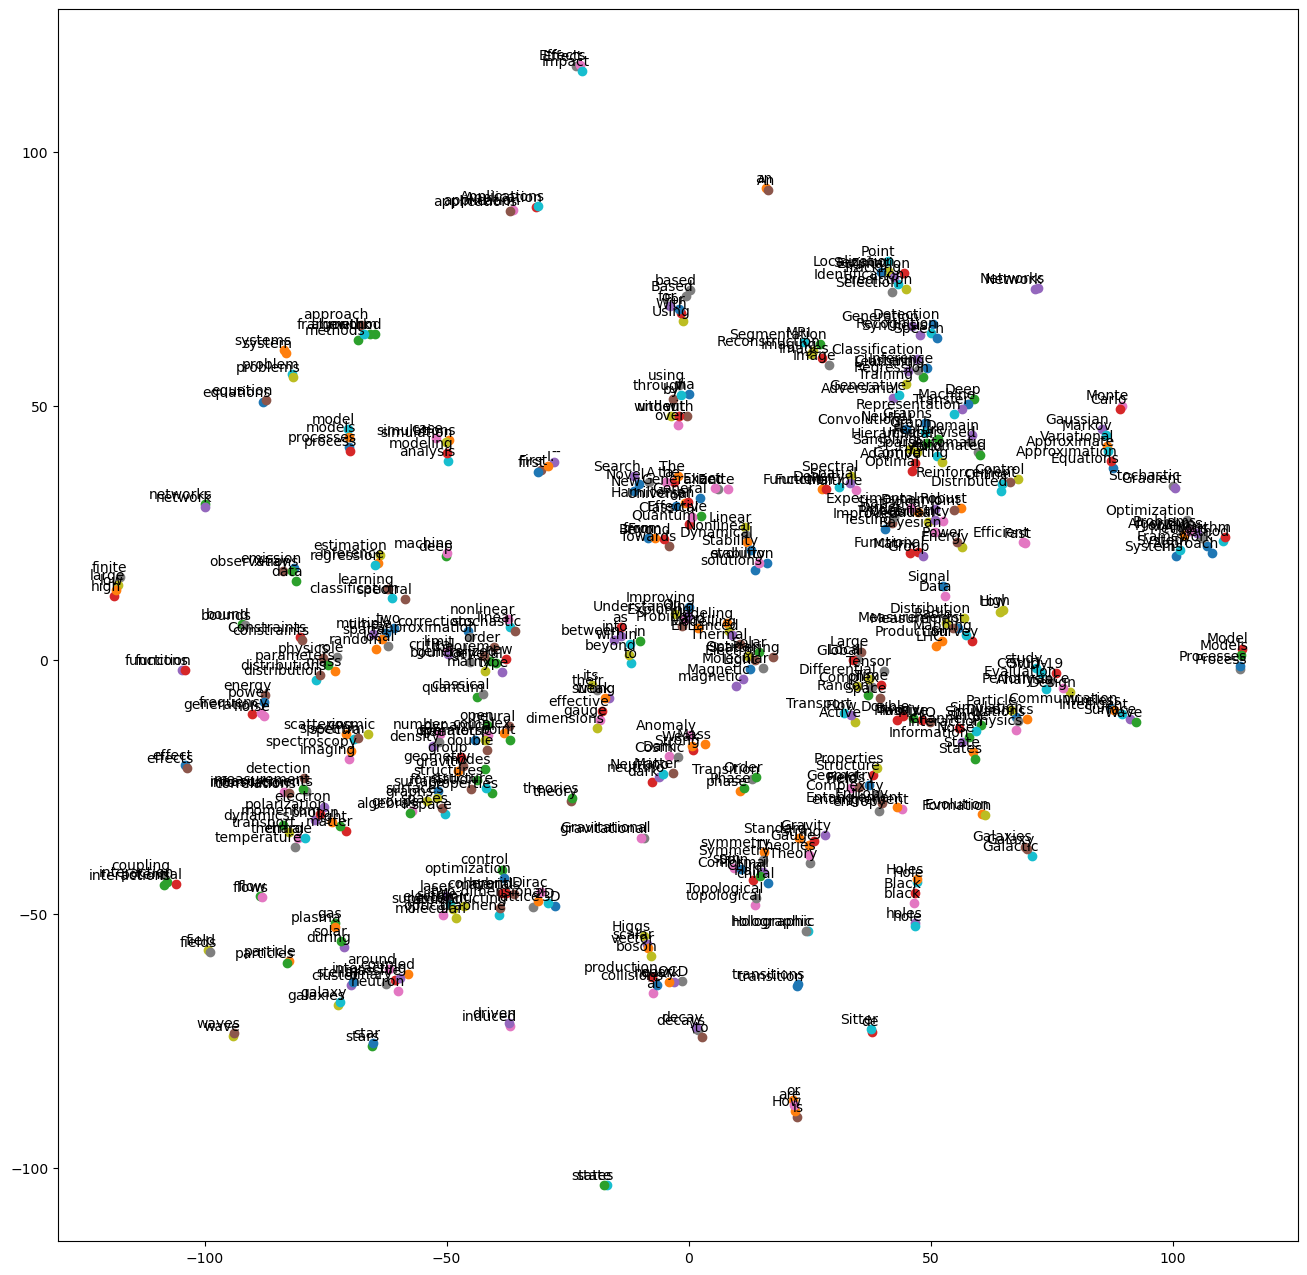

In [161]:
# Plot t-SNE visualization with various combinations of hyperparameters
print("Embedding visualization for vector size = 100, window size = 5, epochs = 10")
tsne_plot(model)

print("Embedding visualization for vector size = 150, window size = 10, epochs = 10")
tsne_plot(model1)

print("Embedding visualization for vector size = 100, window size = 5, epochs = 20")
tsne_plot(model2)

# Getting average word embeddings to represent "Title" and "Abstract"

In [162]:
# Getting average word embeddings for titles
sentence_dict = {}
for i, sentence in enumerate(sentences):
    count = 0
    sentence_sum = np.zeros_like(word_embeddings['example'])
    for word in sentence:
        count +=1
        sentence_sum += word_embeddings[word]
    sentence_dict[i] = sentence_sum/count

# Getting average word embeddings for abstracts
abstract_dict = {}
for i, abstract in enumerate(sentences_a):
    count = 0
    sentence_sum = np.zeros_like(word_embeddings_a['example'])
    for word in abstract:
        count +=1
        sentence_sum += word_embeddings_a[word]
    abstract_dict[i] = sentence_sum/count

In [163]:
# Get labels for each title/abstract

labels = df['label']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [164]:
sentence_embeddings = list(sentence_dict.values())
abstract_embeddings = list(abstract_dict.values())

# Building a fully connected neural network to predict class based on title

In [165]:
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, labels_encoded, test_size=0.2, random_state=13)

In [166]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [167]:
# Fully connected Neural Network, aka multilayer perceptroon (MLP)

class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = len(sentence_embeddings[0])
hidden_dim1 = 256
hidden_dim2 = 128
output_dim = 10
model = MLPModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

In [168]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [169]:
# Training
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataset)}")



Epoch 1/10, Loss: 0.037701718885451554
Epoch 2/10, Loss: 0.034325466786324976
Epoch 3/10, Loss: 0.03327320663779974
Epoch 4/10, Loss: 0.03246760924085975
Epoch 5/10, Loss: 0.031789028362557294
Epoch 6/10, Loss: 0.0312653405431658
Epoch 7/10, Loss: 0.03078649410828948
Epoch 8/10, Loss: 0.03030873842537403
Epoch 9/10, Loss: 0.029886980586871503
Epoch 10/10, Loss: 0.029487189610302448


In [170]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 63.81%


# Building a fully connected neural network to predict class based on abstract

In [171]:
X_train, X_test, y_train, y_test = train_test_split(abstract_embeddings, labels_encoded, test_size=0.2, random_state=13)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_dim = len(abstract_embeddings[0])
hidden_dim1 = 256
hidden_dim2 = 128
output_dim = 10
model = MLPModel(input_dim, hidden_dim1, hidden_dim2, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [172]:
# Training
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataset)}")

Epoch 1/10, Loss: 0.024391225596889853
Epoch 2/10, Loss: 0.020537012837082147
Epoch 3/10, Loss: 0.01951409678477794
Epoch 4/10, Loss: 0.01887064520008862
Epoch 5/10, Loss: 0.018393493859283627
Epoch 6/10, Loss: 0.01802972136773169
Epoch 7/10, Loss: 0.01761926599703729
Epoch 8/10, Loss: 0.0173597809381783
Epoch 9/10, Loss: 0.01708220522198826
Epoch 10/10, Loss: 0.01678331354185939


In [173]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Accuracy on test set: 78.93%


# Discussion

The goal of this notebook is to try to classify scientific papers into one of 10 classes. The dataset is from arxiv.org and contains the title, abstract, and label of 10,000 papers. 

Initially, I used Word2Vec to get embeddings for every word in the title and abstracts of each paper. Next, I took the average of these embeddings for each title and abstract to gain a representation of the pieces of text. 

In the models above, I utilized a fully connected Neural Network with 3 layers to complete the task of classifying the papers. The first model used the embeddings for the titles while the second model used the embeddings for the abstracts. The model that used the embeddings for the abstracts performed much better than the model that used the embeddings for the titles in terms of accuracy on the test set(78.93% vs. 63.81%). This is most likely due to the fact that the abstracts had much more text and so they contained more meaning than the titles. Based on a random classifier predicting the correct class 1/10 times, both of the Neural Networks performed reasonably well for the task. This demonstrates the capability of word embeddings to capture semantic meaning, and how neural networks can effectively learn the relationships between these embeddings and the corresponding labels, resulting in successful classification of scientific papers.


Strengths and Weaknesses of Word2Vec:

Strengths: Word2Vec is good at at capturing semantic relationships between words. It represents words as dense vectors in a continuous space, where similar words are positioned close to each other. Implementing Word2Vec is relatively straightforward, especially with libraries like Gensim. It requires minimal hyperparameter tuning and can produce meaningful embeddings with default settings.

Weaknesses: Word2Vec does not capture contextual information. While it captures semantic similarities well, it doesnt perform well with words that have multiple meanings depending on context. Word2Vec also encounters difficulties with out-of-vocabulary words, especially in specialized domains or with rare terms. These words may not have meaningful embeddings, impacting the overall quality of the representation. In addition, Word2Vec requires a lot of training data in order for the embeddings to be meaningful